In [246]:
from pathlib import Path
from dotenv import dotenv_values
import os

# ROOT
HERE = Path('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my/src')#(os.path.dirname(os.path.abspath(__file__)))
config = dotenv_values(HERE / "root.env")
ROOT = Path(config['ROOT'])
ROOT

PosixPath('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my')

In [247]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [248]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from src.data.download import funsd

#! uncomment this to download.
# funsd() 

In [249]:
import fitz
def file_to_images(file, gray=False):
    if file[-3:].lower() == 'pdf':
        imgs = []
        
        zoom = 3    # zoom factor
        mat = fitz.Matrix(zoom, zoom)
        
        with fitz.open(file) as pdf:
            for pno in range(pdf.page_count):
                page = pdf.load_page(pno)
                pix = page.get_pixmap(matrix=mat)
                # if width or height > 2000 pixels, don't enlarge the image
                #if pix.width > 2000 or pix.height > 2000:
                #    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1)
                
                mode = "RGBA" if pix.alpha else "RGB"                        
                img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)                        
                
                if gray:
                    img = img.convert('L')
                else:
                    img = img.convert('RGB')
                    
                imgs.append(img)
    else:
        if gray:
            img = Image.open(file).convert('L')
        else:
            img = Image.open(file).convert('RGB')
            
        imgs=[img]

    return imgs

Let's visualize an example!

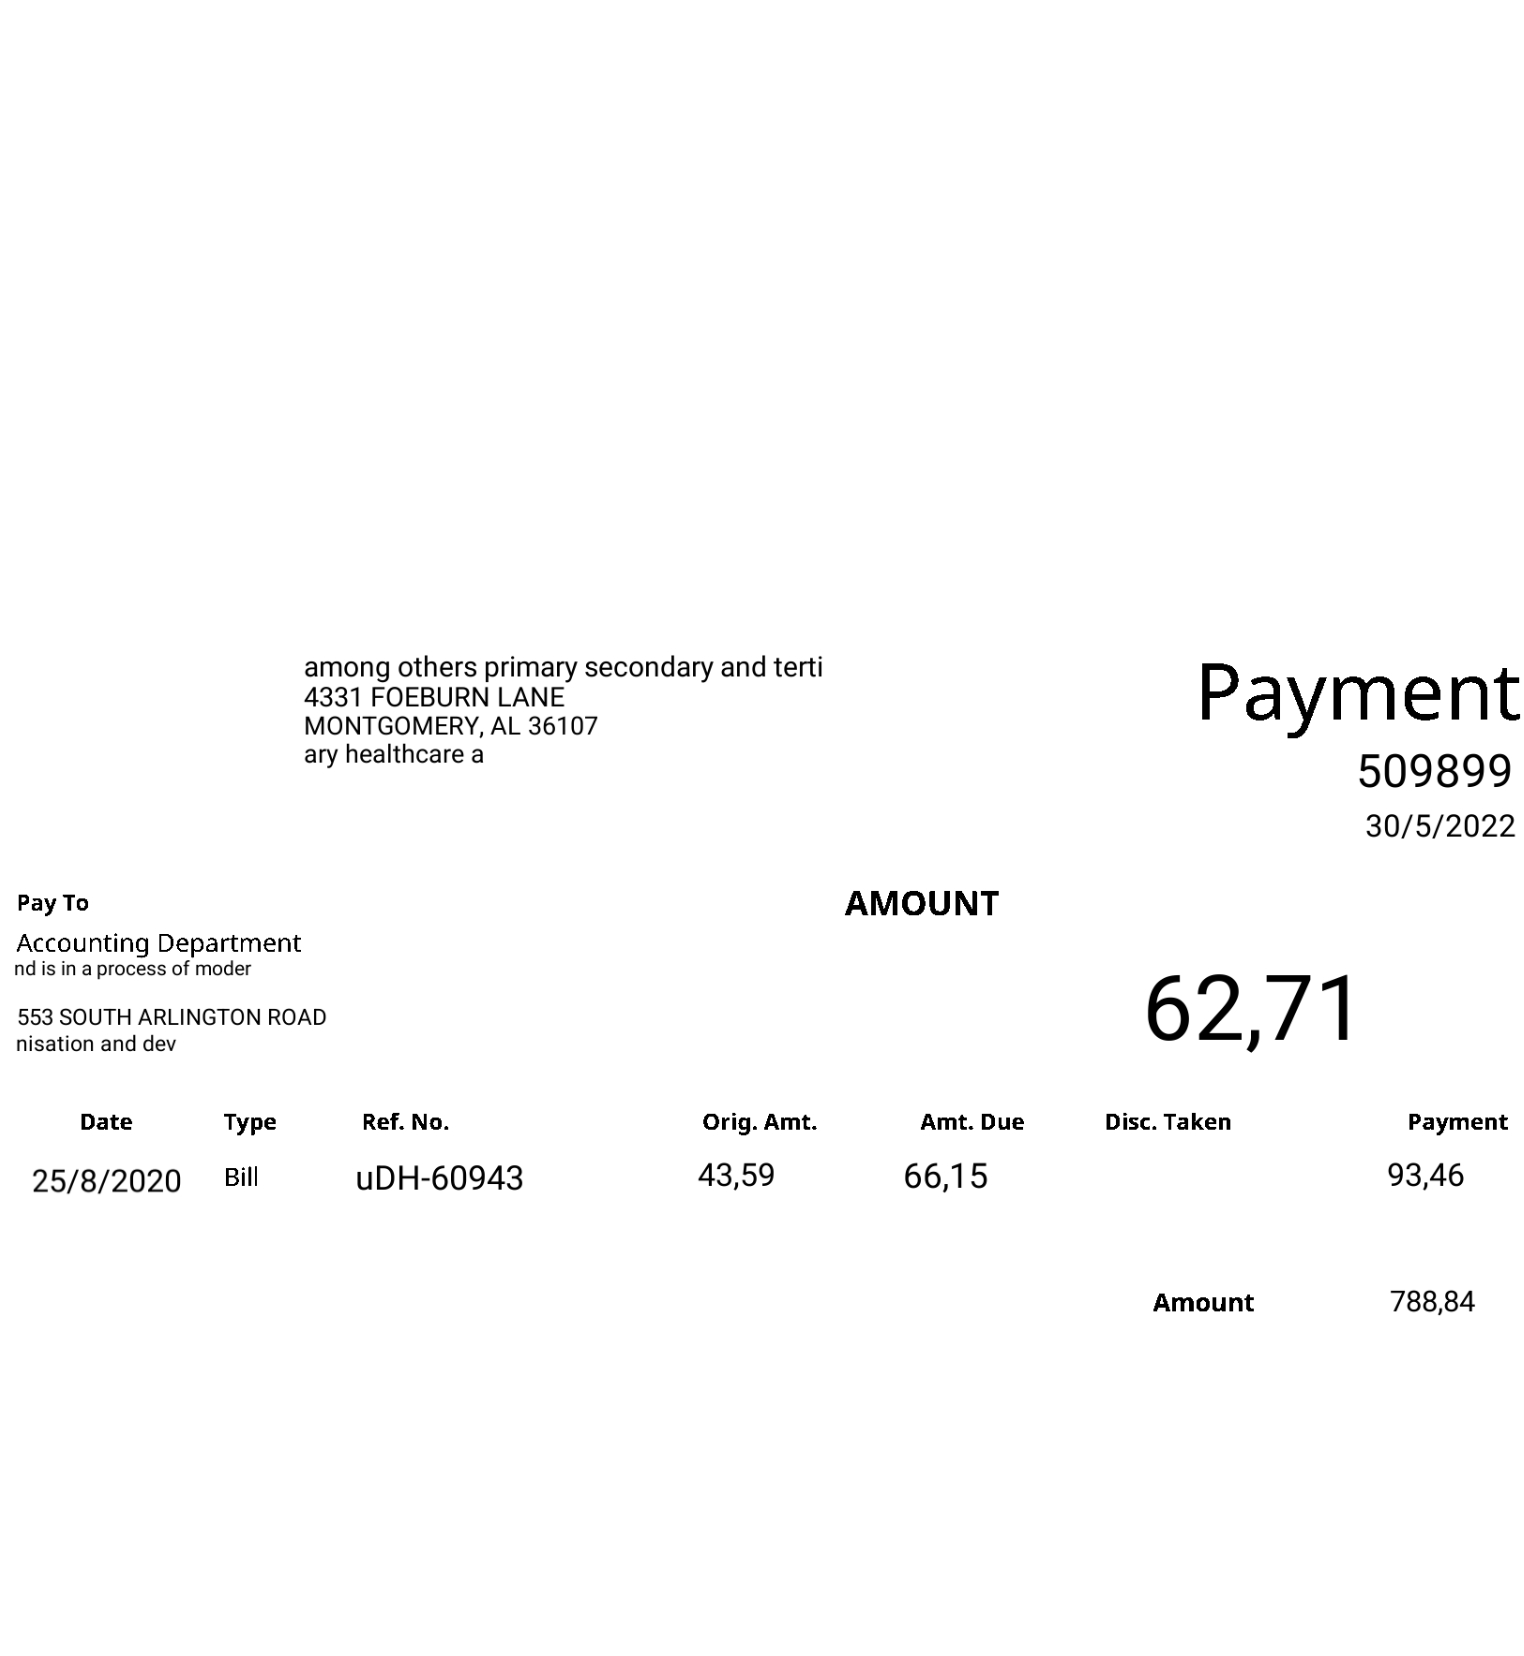

In [252]:
from src.paths import FUNSD_TEST, DATA ,CHECKPOINTS, REMITTANCE_VAL
from PIL import Image, ImageDraw, ImageFont


# funsd_test_images = FUNSD_TEST / 'images'
# image_name = '83996357.png' #! change this to see different outputs from FUNSD, or pass your own image!

funsd_test_images = REMITTANCE_VAL / 'images' 
image_name = '00c325a1-6fe2-43c6-a8de-d01ba451ef91.jpg'
image_path = str(funsd_test_images / image_name)
image = Image.open(image_path).convert('RGB')
#image = file_to_images(image_path)[0]
#image.save(image_path.split('.')[0]+'.jpg')
image

In [253]:
import easyocr

from src.data.preprocessing import center

reader = easyocr.Reader(['en']) #! support multilingual!

def apply_ocr(path):
    result = reader.readtext(path, 
                             min_size=10, 
                            slope_ths=0.2, 
                            ycenter_ths=0.5, 
                            height_ths=0.5, 
                            width_ths=0.5,
                            decoder='wordbeamsearch', 
                            beamWidth=10, )
    boxs, texts = list(), list()

    # transform the OCR result in a handle format
    for r in result:
        box = [int(r[0][0][0]), int(r[0][0][1]), int(r[0][2][0]), int(r[0][2][1])]
        boxs.append(box)
        texts.append(r[1])
    
    return boxs, texts


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [254]:
def draw_results(img, boxs, links, labels):
    draw = ImageDraw.Draw(img)

    for box in boxs:
        draw.rectangle(box, outline='blue', width=3)
    
    if links:
        for idx in range(len(links['src'])):
            key_center = center(boxs[links['src'][idx]])
            value_center = center(boxs[links['dst'][idx]])
            draw.line((key_center, value_center), fill='violet', width=3)
            

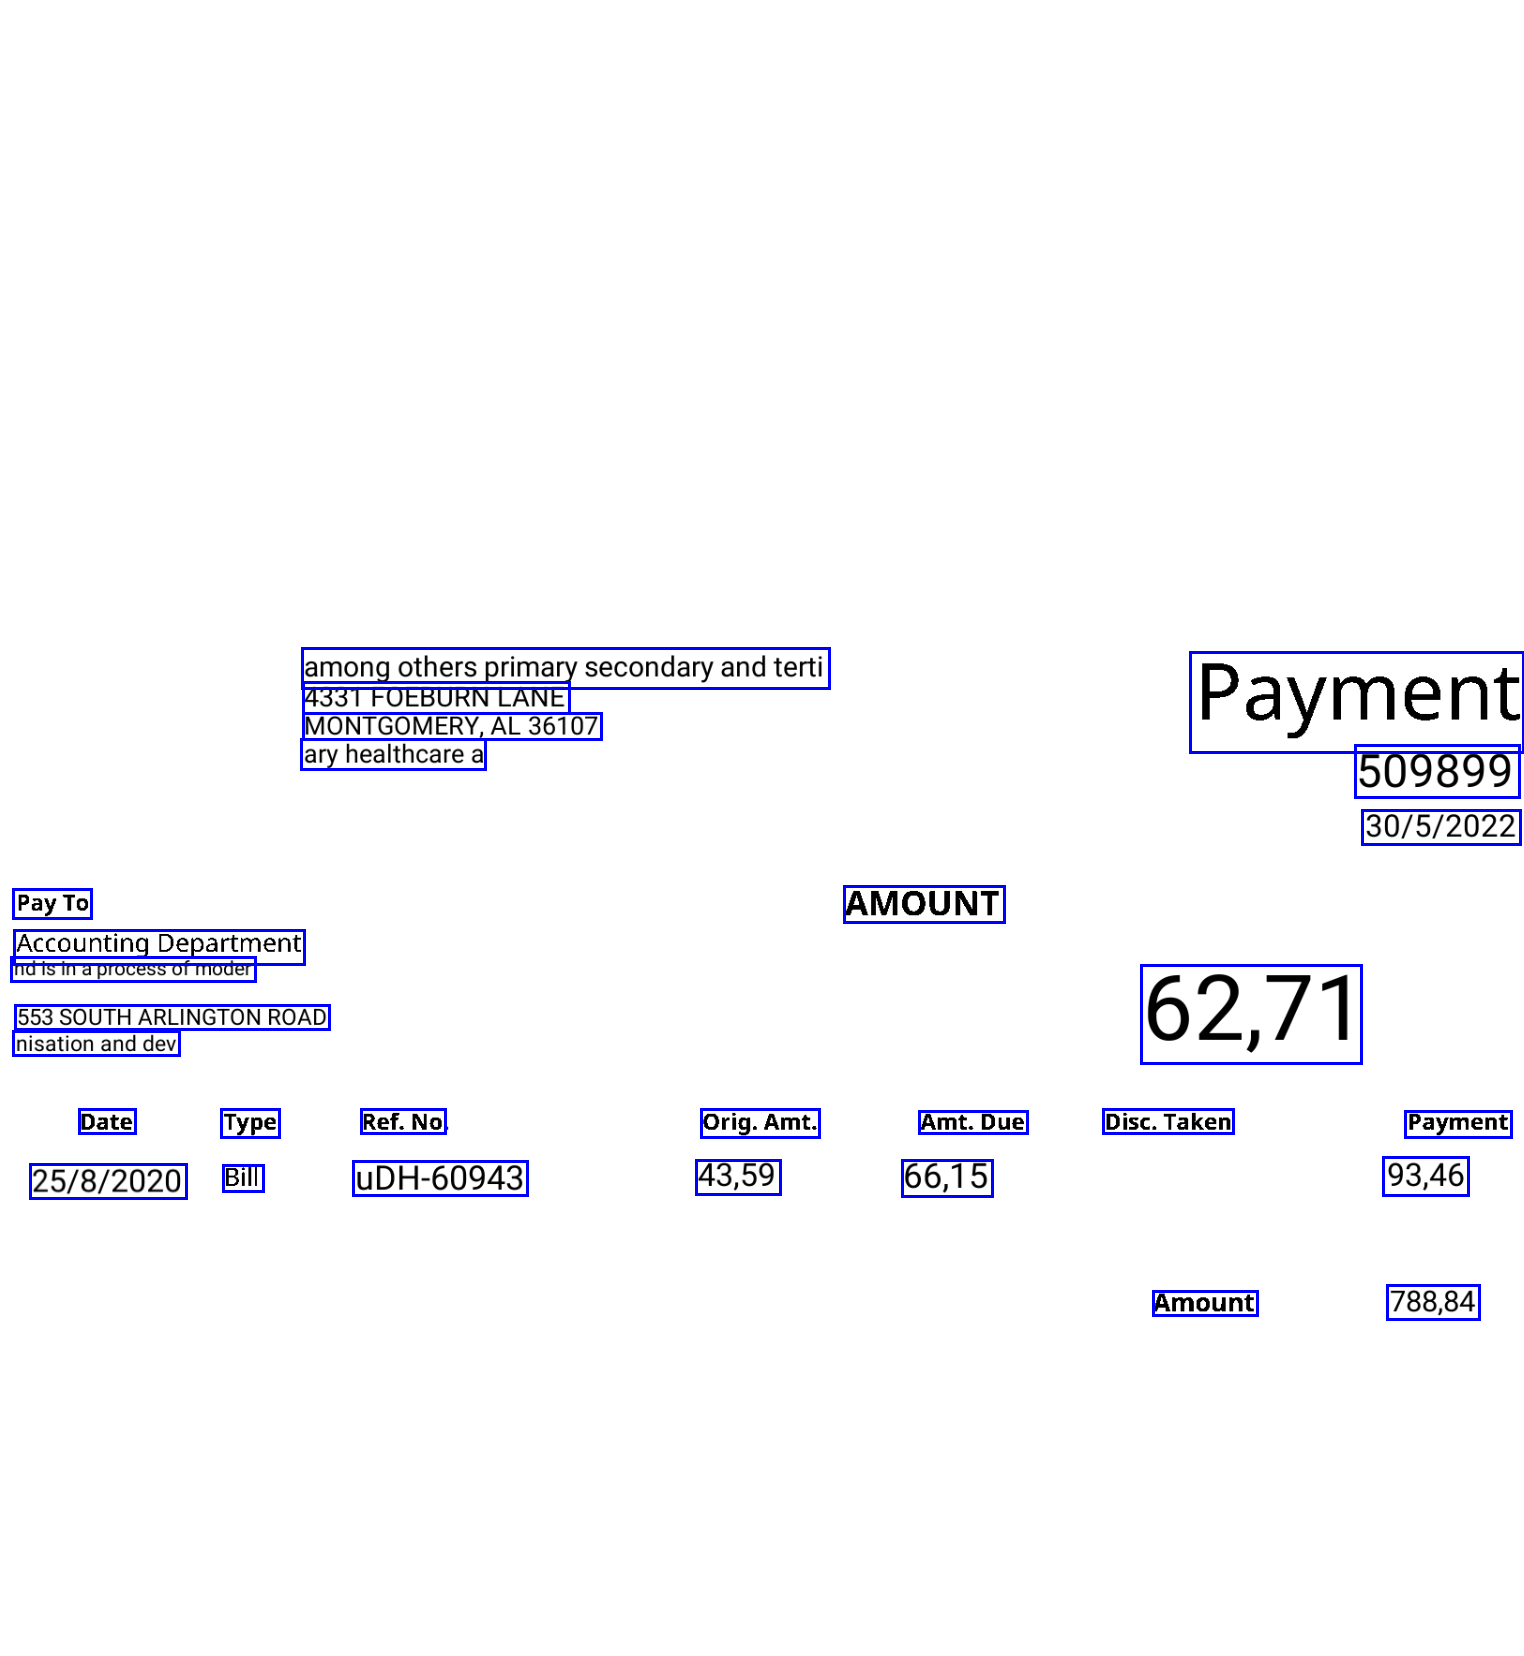

In [256]:
#! get text boxes and contents
#boxs, texts = apply_ocr(image_path)
r_im = image.copy()
res = draw_results(r_im, boxs,None, [])
r_im

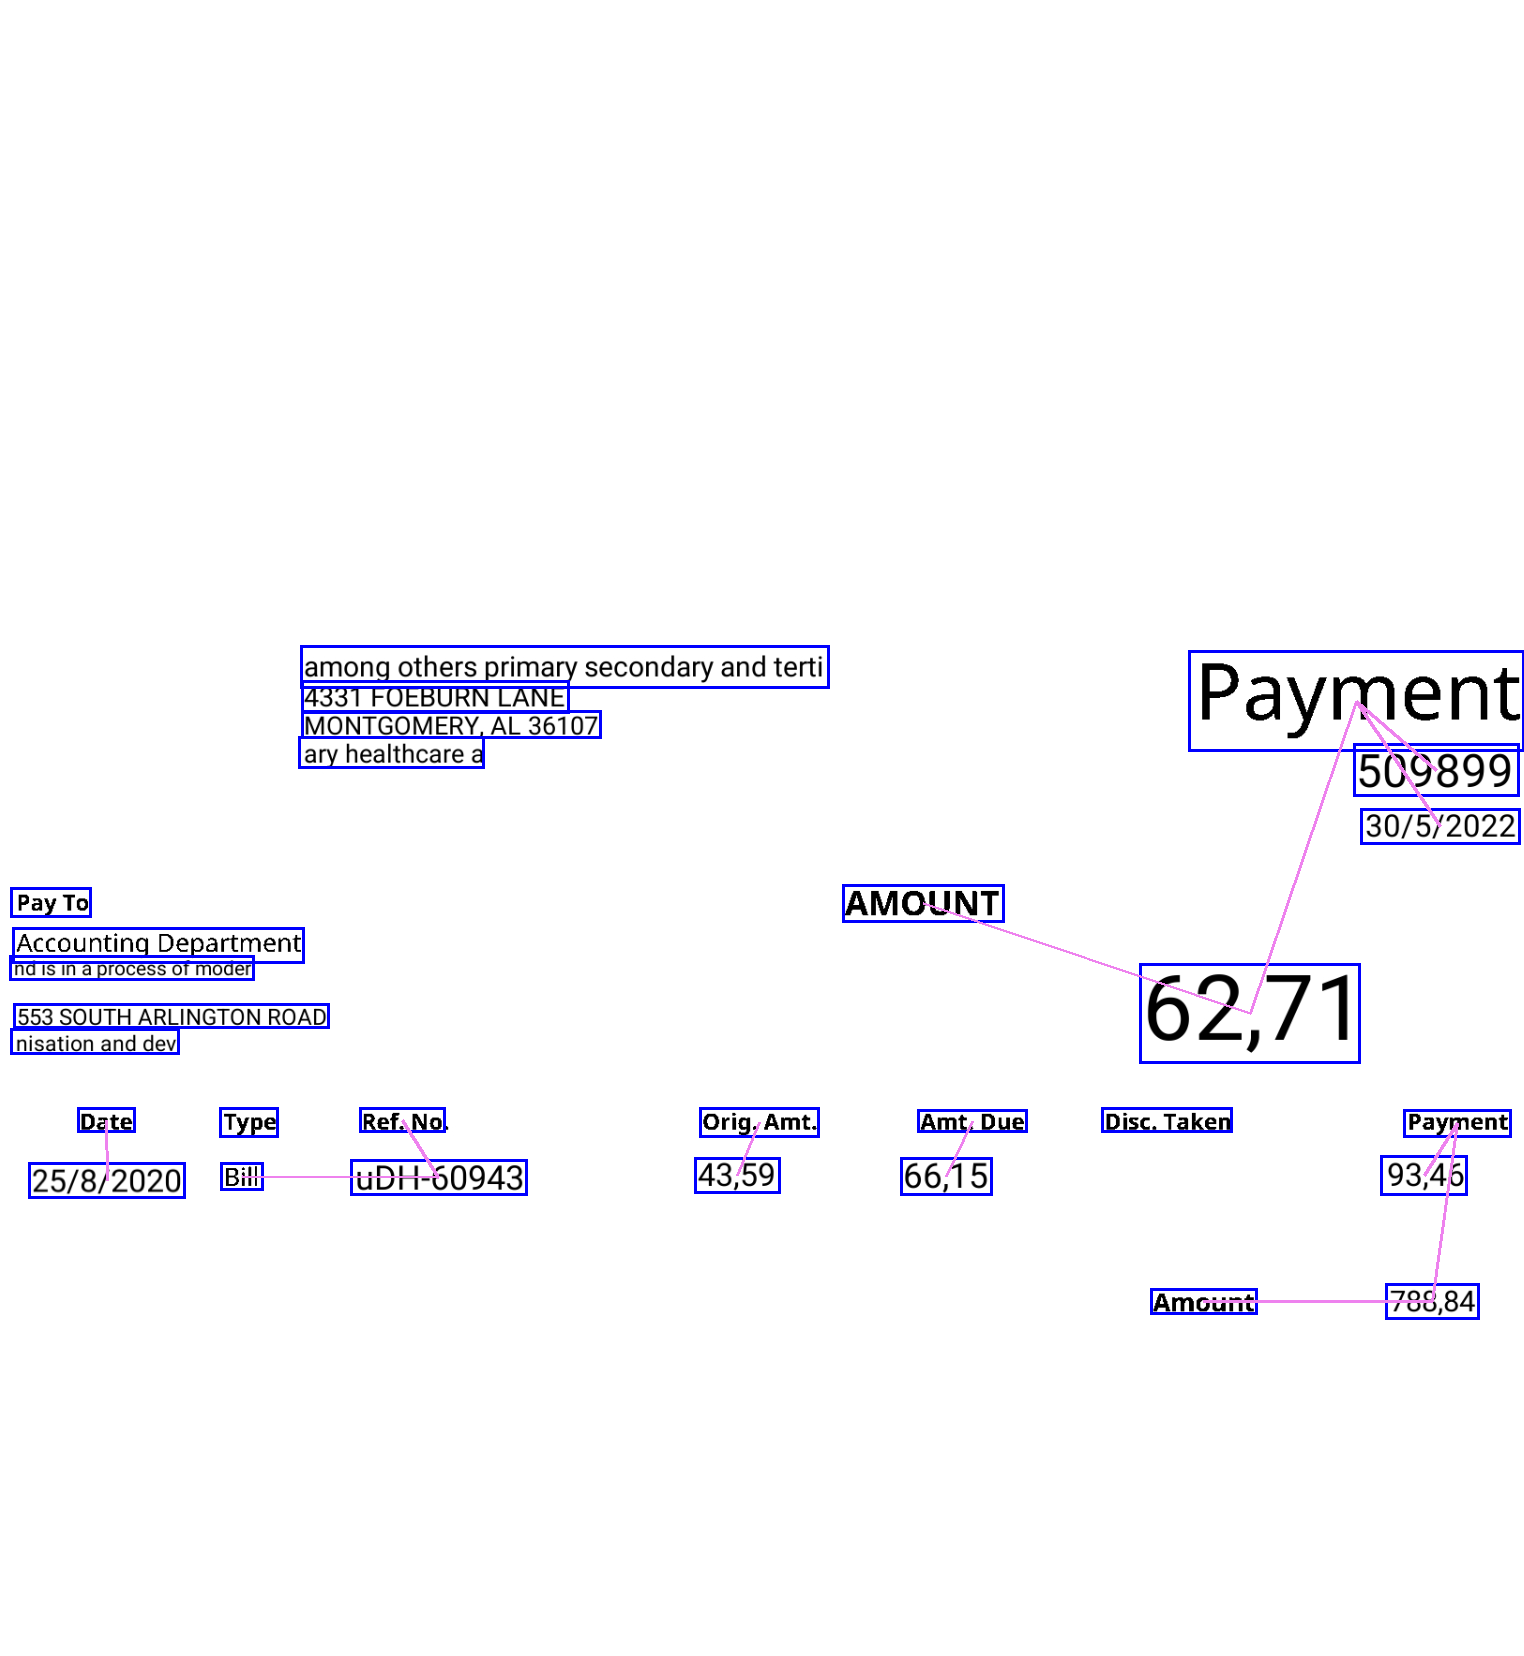

In [737]:
from src.data.graph_builder import GraphBuilder

k = 4 #! try changing this value!

gb = GraphBuilder()
u, v = gb.half_fully_connected2(boxes, texts,2)
links = {'src': u, 'dst': v}
im_c = image.copy()
draw_results(im_c, boxes, links, None)
im_c

In [260]:
gb = GraphBuilder()
graphs, node_labels, edge_labels, features = gb.get_graph([image_path], 'CUSTOM')
graph = graphs[0] # we have only one for this tutorial!
graph

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Graph(num_nodes=29, num_edges=812,
      ndata_schemes={}
      edata_schemes={})

In [261]:
from src.data.feature_builder import FeatureBuilder

device = 'cpu'#'cuda:0' # change this to 'cpu' in case you cannot use hardware acceleration
fb = FeatureBuilder(d=device)

In [262]:
chunks, _ = fb.add_features(graphs, features) # chunks is used by the model to merge different embeddings together!
graphs, chunks

adding features: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


([Graph(num_nodes=29, num_edges=812,
        ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(306,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32)})],
 [300, 6])

In [263]:
graph.ndata['geom'].shape, graph.edata['feat'].shape

(torch.Size([29, 4]), torch.Size([812, 4]))

In [742]:
u,v = graph.edges()

In [1181]:
import torch
from src.models.graphs import SetModel
from src.paths import CHECKPOINTS

device = 'cpu'
sm = SetModel(name='gat', device=device)
model = sm.get_model(7, 4, [300], False) # 4 and 2 refers to nodes and edge classes, check paper for details!
model.load_state_dict(torch.load(CHECKPOINTS / 'gat-20230807-1428.pt', map_location=torch.device('cpu'))) # load pretrained model
model.eval()


### MODEL ###
-> Using GAT
-> Total params: 468447
-> Device: False



GAT(
  (drop): Dropout(p=0.2, inplace=False)
  (node_projector): InputProjector(
    (modalities): Sequential(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
        (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (edge_projector): InputProjector(
    (modalities): Sequential(
      (0): Sequential(
        (0): Linear(in_features=4, out_features=20, bias=True)
        (1): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (message_passing): GATConv(300, 300, heads=2)
  (node_pred): Sequential(
    (0): Linear(in_features=600, out_features=300, bias=True)
    (1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=7, bias=True)
  

In [656]:

# from src.data.dataloader import Document2Graph
# from src.paths import TEST_SAMPLES, INF, REMITTANCE_TEST

# test_data = Document2Graph(name='REMITTANCE TEST', src_path=INF, device = device, output_dir=TEST_SAMPLES)
# test_data.get_info()

In [269]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [265]:
from torch_geometric.data import Data
pygraph = Data()
dgl_graph = graphs[0]
        
geometric_graph = Data(x=dgl_graph.ndata['feat'], 
                        edge_index= torch.stack(dgl_graph.edges(), dim=0).to(torch.int64), 
                        edge_attr= dgl_graph.edata['feat'])

geometric_graph = geometric_graph.to(device)
geometric_graph['geom'] = dgl_graph.ndata['geom']

In [266]:
node_unique_labels =['O', 'invoice_amount', 'invoice_date', 'invoice_number', 'payment_amount', 'payment_date', 'payment_number']

In [270]:
from torch.nn import functional as F
import numpy as np
from src.training.utils import *

ind=1
#graph = test_data.graphs[ind]
#inference = Image.open(test_data.paths[ind]).convert('RGB')
graph = graphs[0]
inference = image.copy()
size = inference.size

boxes = list(graph.ndata['geom'].numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]

with torch.no_grad():
    n = model(geometric_graph.to(device))
    score, npreds = torch.max(F.softmax(n, dim=1), dim=1)
    
    arr = npreds.numpy()
    li = list(np.where(arr>0)[0]) 
    
    labels = [node_unique_labels[arr[i]]+f'%6.2f' %score[i] for i in li]
    score = [f'%6.2f' % score[i] for i in li]

    # save results
    links = (epreds == 1).nonzero(as_tuple=True)[0].tolist()
    
    entities = [boxes[i] for i in li]

    inference = draw_boxes(inference, entities, labels)
    
inference

NameError: name 'model' is not defined

# Test

In [185]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 2],
                           [1, 1, 1]], dtype=torch.long)
x = torch.tensor([[1], [1], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [717]:
from src.main import seed_everything
from src.models.utils import GATConvM

import os
import random
import numpy as np
import torch
import pytorch_lightning as pl


seed = 42
#random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

edge_index = torch.tensor([[1, 2, 3,1,2], [0, 0, 0,1,2]], dtype=torch.long)  # 2 x E
edge_attr = torch.tensor([[1,2], [1,2], [1,2], [1,2],[1,2]], dtype=torch.float)
x = torch.tensor([[1,1], [2,2], [3,3], [4,4]], dtype=torch.float)  # N x emb(in)
x, edge_index

conv1 = GATConvM(2, 2, add_self_loops = False,  bias = False, edge_dim = 2)
conv1(x, edge_index, edge_attr)

tensor([[0.0657, 1.1494, 0.2504, 4.3802],
        [0.1314, 2.2987, 0.1314, 2.2987],
        [0.1971, 3.4481, 0.1971, 3.4481],
        [0.2628, 4.5974, 0.0000, 0.0000]], grad_fn=<ViewBackward0>)

In [750]:
from src.data.dataloader import Document2Graph
from src.paths import *

In [844]:
#test_data = Document2Graph(name='REMITTANCE TEST', src_path=REMITTANCE_TEST, device = device, output_dir=TEST_SAMPLES)
#test_data.get_info()
inf_data = Document2Graph(name='REMITTANCE INFERENCE', src_path=REMITTANCE_INFERENCE, device = device, output_dir=INFERENCE_SAMPLES)
inf_data.get_info()
test_data = inf_data

adding features: 100%|██████████| 10/10 [00:00<00:00, 37.02it/s]


REMITTANCE INFERENCE dataset:
-> graphs: 10
-> node labels: ['O' 'payment_amount']
-> edge labels: ['none']
-> node features: 6
-> edge type: fully
-> textual feats: False
                 -> visual feats: False
                 -> geom feats: False
                 -> size feats: False
                 -> edge epolar: False
                 -> edge edist: True
-> graph example: Graph(num_nodes=43, num_edges=18,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(6,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [851]:
idx=1
data = test_data[idx]

In [859]:
x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

In [860]:
from src.models.utils import GCNConvM, SAGEConvM, InputProjectorSimple, GATConvM, GATv2ConvM
conv = GATv2ConvM(5, 5, edge_dim = 2, heads=1, dropout = 0, v2 = True, add_self_loops = False, aggr='add', bias=False)
x_new = conv(x, edge_index)

In [862]:
geom = data['geom']
text = data['text']
for i in range(geom.shape[0]):
    print(list(x_new[i].detach().numpy()), text[i], data.y[i].numpy() ) #list(geom[i].numpy()), list(data.x[i].numpy()),'->',

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] P.O 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Box 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 248 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Vendor 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ACP 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Green 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Bay, 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] WI 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 54305 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (920) 435-5353 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Fax (920) 438-0389 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Payment 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] cccp.com 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] CreativIT 0
[0.0, 0.0, 0.0

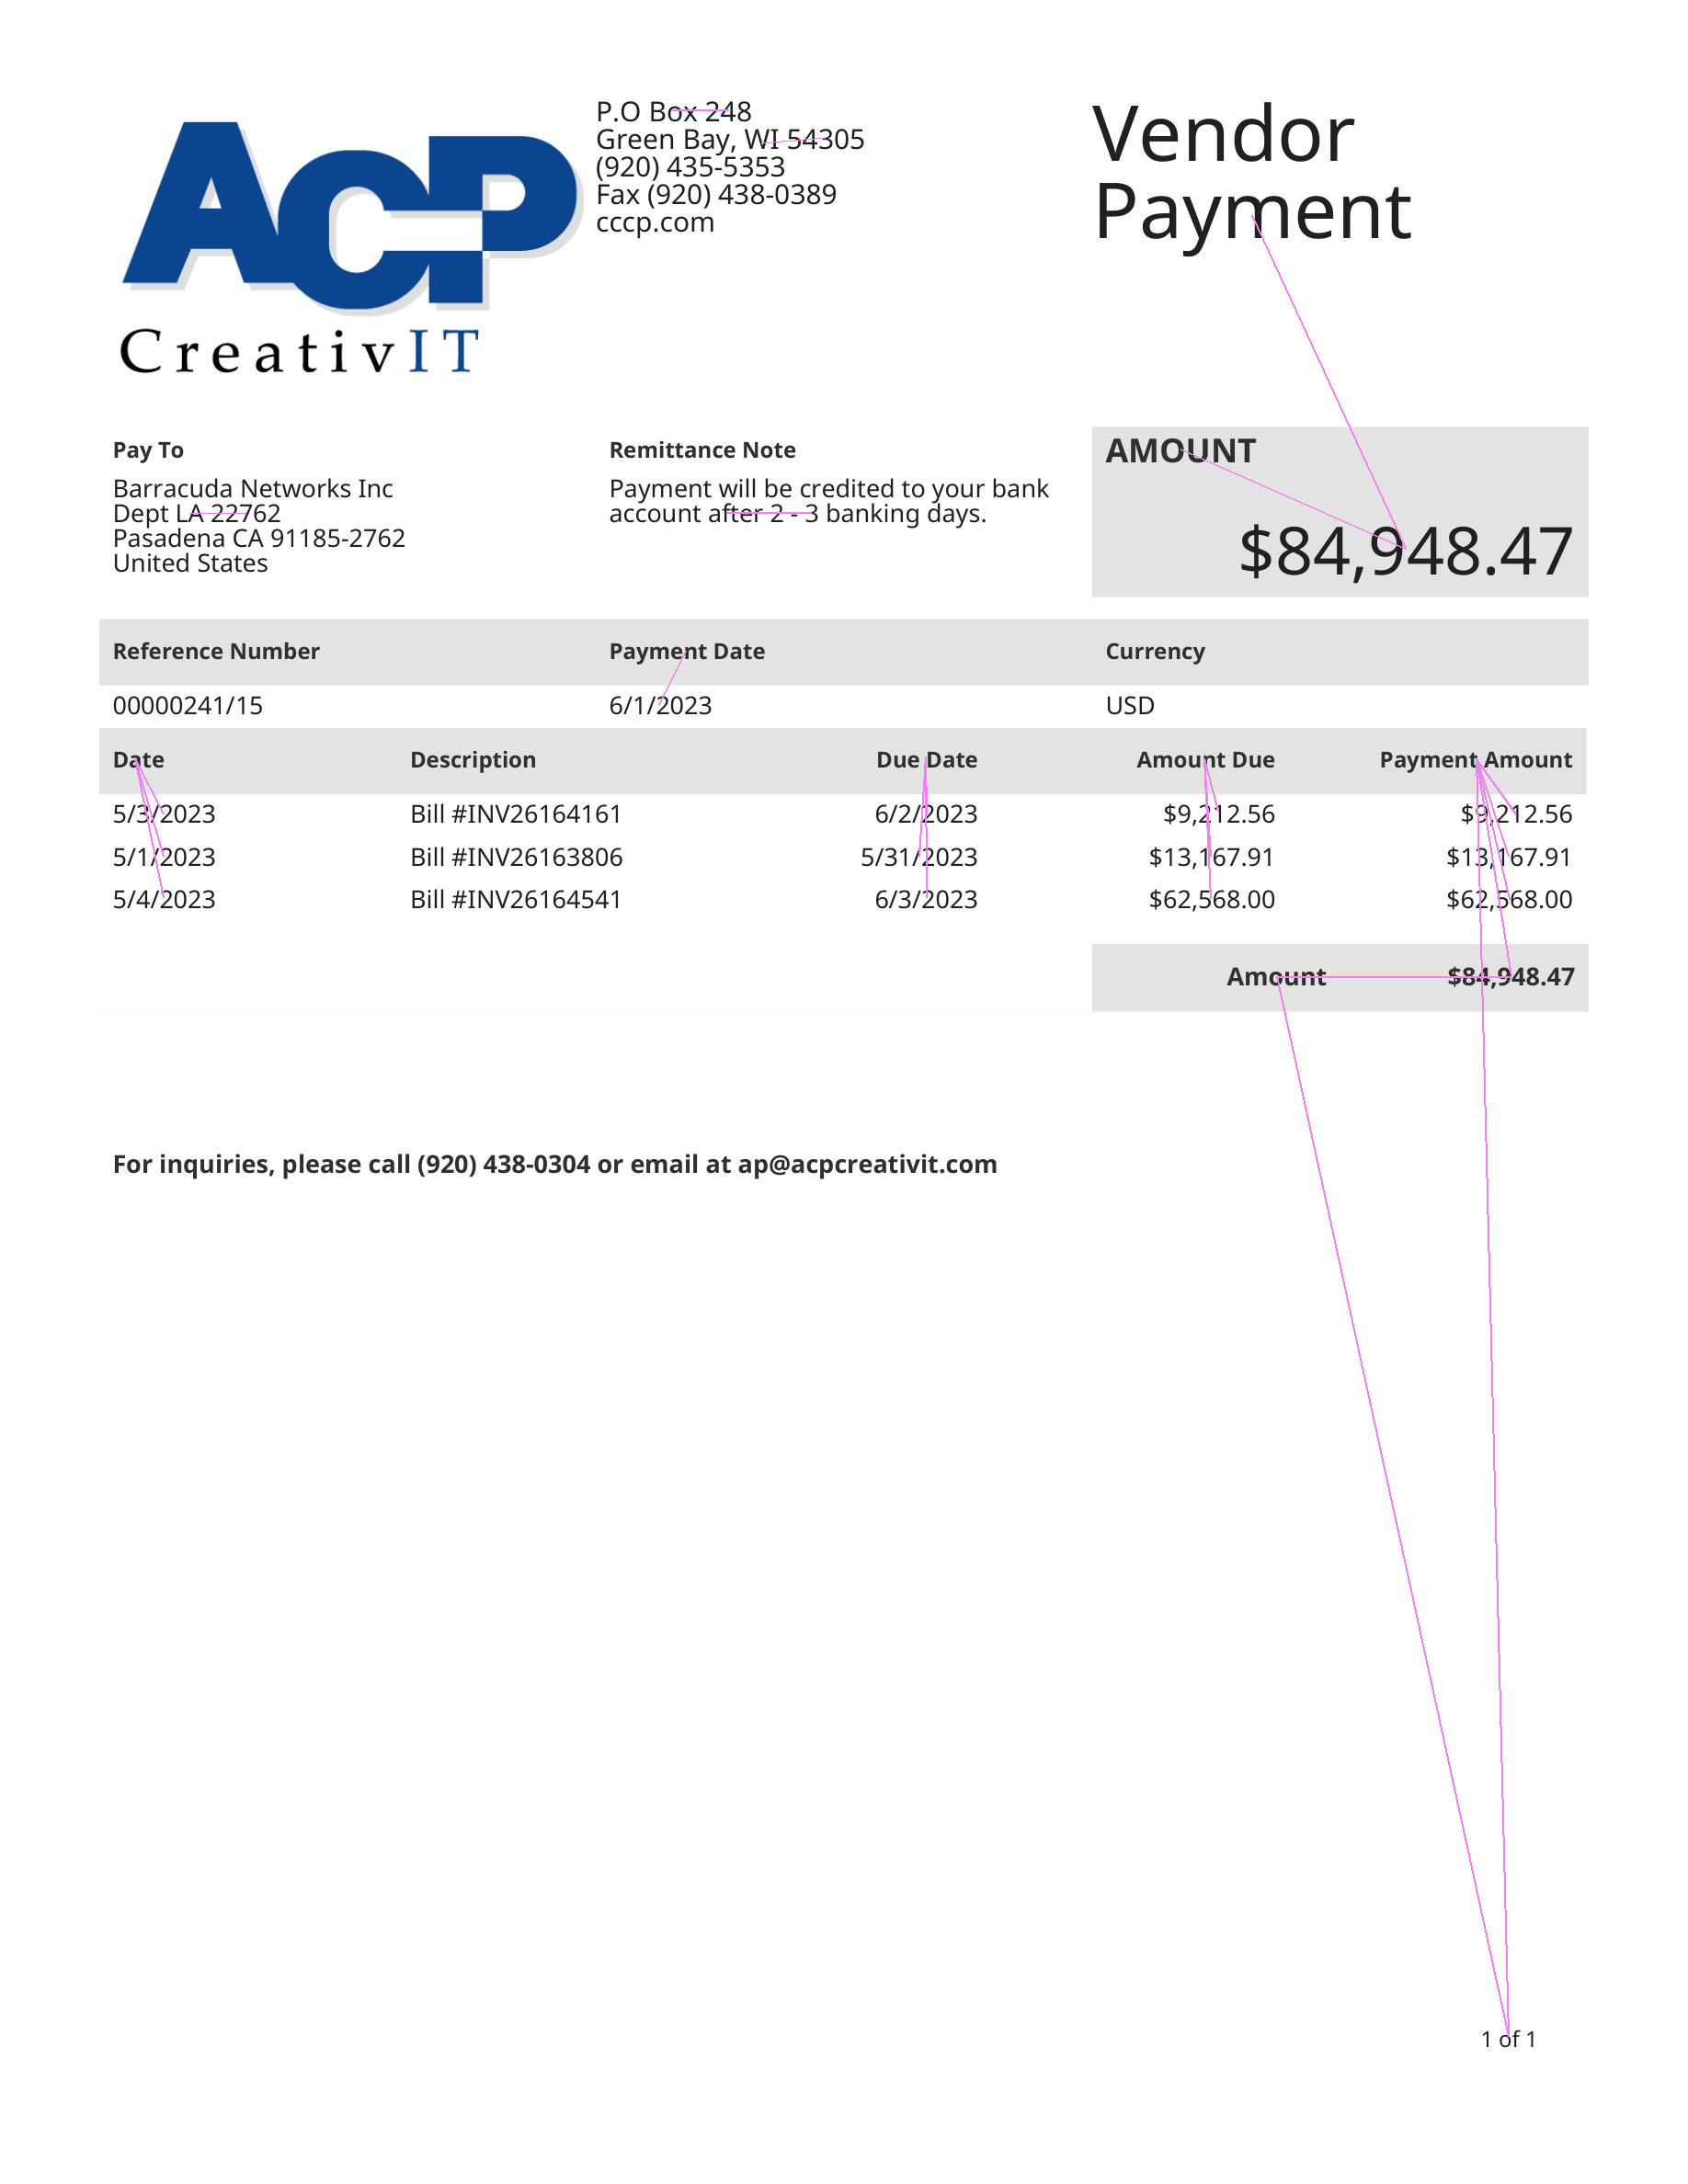

In [856]:
from src.data.preprocessing import unnormalize_box, draw_boxes


img_path = test_data.paths[idx]
img_name = os.path.basename(img_path)
        
inference = Image.open(img_path).convert('RGB')
size = inference.size

boxes = list(geom.numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]
        
u, v = test_data.graphs[idx].edges()
links = {'src': u, 'dst': v}
        
inference = draw_boxes(inference, boxes, [], labels=None, links = links, scores=None)
inference